In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

import captum
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients

from msa import MSA

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import sklearn.metrics as metrics

import umap

from redundancy_remover import compress_seqs

/home/users/khoang99/.local/lib/python3.9/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


All tests passed


In [495]:
alphabet_dict = {"-": 0, "A": 1, "C": 2, "G": 3, "T": 4}
lab2onehot =  lambda seq: torch.eye(len(alphabet_dict))[seq]
seq2lab = lambda seq: torch.tensor([alphabet_dict[i] for i in seq])

In [496]:
def label(seqs, alphabet_dict):
    assert any(seqs), "empty sequence input"
    assert any([len(seq) != len(seq[0]) for seq in seqs])
    encoded_seqs = torch.ones((len(seqs), len(seqs[0])))
    for i,seq in enumerate(seqs):
        encoded_seq = torch.tensor([alphabet_dict[a] for a in seq])
        encoded_seqs[i,:] = encoded_seq
    return encoded_seqs

def onehot(seqs, alphabet_dict):
    assert any(seqs), "empty sequence input"
    assert any([len(seq) != len(seq[0]) for seq in seqs])
    encoded_seqs = torch.ones((len(seqs), len(seqs[0]), len(alphabet_dict)))
    for i,seq in enumerate(seqs):
        encoded_seq = seq2lab(seq)
        encoded_seq_onehot = lab2onehot(encoded_seq)
        encoded_seqs[i,:,:] = encoded_seq_onehot
    return encoded_seqs

def calculate_prob_matrix(seqs, alphabet_dict):    
    onehot_vect = onehot(seqs, alphabet_dict)
    return (onehot_vect.sum(dim=0).T / onehot_vect.sum(dim=[0,2])).T

In [111]:
class Autoencoder(nn.Module):
    def __init__(self, num_channels):
        super(Autoencoder, self).__init__()
        
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv1d(num_channels, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )
        
        # Bottleneck linear layer
        self.bottleneck = nn.Linear(2048, 128)  # Adjust your_input_length
        
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose1d(64, num_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid activation for the output to constrain values between 0 and 1
        )

    def l1_regularization(self):
        l1_reg = 0.0
        for param in self.encoder.parameters():
            l1_reg += torch.sum(torch.abs(param))
        return l1_reg

    def forward(self, x):
        # print(x.shape)
        x = self.encoder(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        # print(x.shape)
        x = self.bottleneck(x)
        # print(x.shape)
        x = x.view(x.size(0), 32, -1)
        # print(x.shape)
        x = self.decoder(x)  # Adjust your_input_length
        # print(x.shape)
        return x

    def encode(self, x):
        x = self.encoder(x)
        x = x.view(x.size(0), -1)
        x = self.bottleneck(x)
        return x

In [501]:
path = "/oak/stanford/groups/horence/khoa/data/splash_classification/aligned_subset_TSP_SS2_tissue-TSP5-Eye-classified_compactors.csv"
path = "/oak/stanford/groups/horence/khoa/data/splash_classification/aligned_subset_TSP_SS2_tissue-TSP7-Blood-classified_compactors.csv"

df_aligned = pd.read_csv(path)
df_aligned.anchor_event.unique()

array(['Base_pair_change_1', 'Base_pair_change_6', 'Base_pair_change_7',
       'Internal_splicing', 'Repeat', '3UTR', 'Centromere', 'splicing'],
      dtype=object)

In [502]:
#filter for anchor event == splicing or centromere
df_aligned = df_aligned[df_aligned["anchor_event"].isin(["splicing", "3UTR"])]
df_aligned_group = df_aligned.groupby("anchor_index").agg(list).reset_index()
df_aligned.anchor_event.unique()


array(['3UTR', 'splicing'], dtype=object)

In [503]:
all_msa = []
for i, row in df_aligned_group.iterrows():
    msa = MSA(anchor=row["anchor_index"], \
              seqs=row["compactor_valid"], \
              aligned_seqs=row["aligned_compactor"], \
              alphabet_dict=alphabet_dict, \
              counts=row["valid_abundance"])
    all_msa.append(msa)
    
candidates = [msa_seq.longest_seq for msa_seq in all_msa]
non_redudant_seqs, non_redundant_indices = compress_seqs(candidates)
original_labels = df_aligned_group.anchor_event.apply(lambda x: x[0]).to_list()
non_redundant_labels = [original_labels[i] for i in non_redundant_indices]
non_redundant_msa = [all_msa[i] for i in non_redundant_indices]

msa_prob_encoded = [msa.prob_matrix for msa in non_redundant_msa]
padded_sequences = pad_sequence(msa_prob_encoded, batch_first=True, padding_value=0)
input_seqs = torch.swapaxes(padded_sequences, 1,2)
input_seqs.shape

Reduce from 11045 to 5865
Reduce from 5865 to 5568
Reduce from 5568 to 5544
Reduce from 5544 to 5544


torch.Size([5544, 5, 132])

In [505]:
Counter(non_redundant_labels)

Counter({'3UTR': 4301, 'splicing': 1243})

In [506]:
msa_prob_encoded_balanced = []
non_redundant_labels_balanced = []
for lab, seq in tuple(zip(non_redundant_labels, msa_prob_encoded)):
    if lab == "3UTR":
        if np.random.random() < 0.3:
            msa_prob_encoded_balanced.append(seq)
            non_redundant_labels_balanced.append(lab)
    else:
        msa_prob_encoded_balanced.append(seq)
        non_redundant_labels_balanced.append(lab)
padded_sequences = pad_sequence(msa_prob_encoded_balanced, batch_first=True, padding_value=0)
input_seqs = torch.swapaxes(padded_sequences, 1,2) 
input_seqs.shape

torch.Size([2600, 5, 130])

In [508]:
Counter(non_redundant_labels_balanced)

Counter({'3UTR': 1357, 'splicing': 1243})

In [491]:
msa_prob_encoded_truncated_splicing = []
for lab, seq in tuple(zip(non_redundant_labels_balanced, msa_prob_encoded_balanced)):
    if lab == "splicing":
        seq = seq[10:,:]
    msa_prob_encoded_truncated_splicing.append(seq)
padded_sequences = pad_sequence(msa_prob_encoded_truncated_splicing, batch_first=True, padding_value=0)
input_seqs = torch.swapaxes(padded_sequences, 1,2) 

In [492]:
input_seqs.shape

torch.Size([711, 5, 130])

In [493]:
Counter(non_redundant_labels_balanced)

Counter({'3UTR': 340, 'splicing': 371})

In [115]:
# divide into train and test set
train_size = int(0.8 * len(input_seqs))
test_size = len(input_seqs) - train_size
train_set, test_set = torch.utils.data.random_split(input_seqs, [train_size, test_size])
print("train set size: ", len(train_set))
print("test set size: ", len(test_set))

train set size:  572
test set size:  143


In [116]:
# use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
# Instantiate the model
model = Autoencoder(5)

# Choose a loss function (e.g., Mean Squared Error) and an optimizer (e.g., Adam)
# use cross entropy loss for classification
# cross_entropy = nn.CrossEntropyLoss()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
train_loss = []
test_loss = []
for epoch in range(num_epochs):

    # train in batch
    batch_size = 128
    for i in range(0, len(train_set), batch_size):
        batch = train_set[i:i+batch_size]
        outputs = model(batch)
        reconstruction_loss = criterion(outputs, batch)
        sparsity_loss = 0.0000 * model.l1_regularization()
        loss = reconstruction_loss + sparsity_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # # Forward pass
    # outputs = model(train_set.dataset[train_set.indices])
    # loss = criterion(outputs, train_set.dataset[train_set.indices])

    # # Backward pass and optimization
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    # Print progress
    with torch.no_grad():
        print("Sparsity_Loss = ", sparsity_loss.item())
        outputs = model(train_set.dataset[train_set.indices])
        train_loss_ = criterion(outputs, train_set.dataset[train_set.indices])
        print(f'Epoch [{epoch + 1}/{num_epochs}]')
        print(f'Train loss: {train_loss_.item():.4f}')
        outputs = model(test_set.dataset[test_set.indices])
        test_loss_ = criterion(outputs, test_set.dataset[test_set.indices])
        print(f'Test loss: {test_loss_.item():.4f}')

    # save test loss and rain loss in lists
    train_loss.append(train_loss_.item())
    test_loss.append(test_loss_.item())

# Test the model
with torch.no_grad():
    outputs = model(test_set.dataset[test_set.indices])
    loss = criterion(outputs, test_set.dataset[test_set.indices])
    print(f'Test loss: {loss.item():.4f}')

Using cuda device
Sparsity_Loss =  0.0
Epoch [1/300]
Train loss: 0.2205
Test loss: 0.2205
Sparsity_Loss =  0.0
Epoch [2/300]
Train loss: 0.1991
Test loss: 0.1990
Sparsity_Loss =  0.0
Epoch [3/300]
Train loss: 0.1334
Test loss: 0.1329
Sparsity_Loss =  0.0
Epoch [4/300]
Train loss: 0.1266
Test loss: 0.1262
Sparsity_Loss =  0.0
Epoch [5/300]
Train loss: 0.1247
Test loss: 0.1240
Sparsity_Loss =  0.0
Epoch [6/300]
Train loss: 0.1195
Test loss: 0.1188
Sparsity_Loss =  0.0
Epoch [7/300]
Train loss: 0.1123
Test loss: 0.1116
Sparsity_Loss =  0.0
Epoch [8/300]
Train loss: 0.1056
Test loss: 0.1049
Sparsity_Loss =  0.0
Epoch [9/300]
Train loss: 0.1021
Test loss: 0.1017
Sparsity_Loss =  0.0
Epoch [10/300]
Train loss: 0.0999
Test loss: 0.0997
Sparsity_Loss =  0.0
Epoch [11/300]
Train loss: 0.0987
Test loss: 0.0984
Sparsity_Loss =  0.0
Epoch [12/300]
Train loss: 0.0984
Test loss: 0.0981
Sparsity_Loss =  0.0
Epoch [13/300]
Train loss: 0.0982
Test loss: 0.0978
Sparsity_Loss =  0.0
Epoch [14/300]
Train 

Sparsity_Loss =  0.0
Epoch [113/300]
Train loss: 0.0837
Test loss: 0.0860
Sparsity_Loss =  0.0
Epoch [114/300]
Train loss: 0.0835
Test loss: 0.0858
Sparsity_Loss =  0.0
Epoch [115/300]
Train loss: 0.0832
Test loss: 0.0856
Sparsity_Loss =  0.0
Epoch [116/300]
Train loss: 0.0830
Test loss: 0.0855
Sparsity_Loss =  0.0
Epoch [117/300]
Train loss: 0.0829
Test loss: 0.0855
Sparsity_Loss =  0.0
Epoch [118/300]
Train loss: 0.0827
Test loss: 0.0854
Sparsity_Loss =  0.0
Epoch [119/300]
Train loss: 0.0824
Test loss: 0.0852
Sparsity_Loss =  0.0
Epoch [120/300]
Train loss: 0.0821
Test loss: 0.0849
Sparsity_Loss =  0.0
Epoch [121/300]
Train loss: 0.0829
Test loss: 0.0856
Sparsity_Loss =  0.0
Epoch [122/300]
Train loss: 0.0817
Test loss: 0.0847
Sparsity_Loss =  0.0
Epoch [123/300]
Train loss: 0.0815
Test loss: 0.0846
Sparsity_Loss =  0.0
Epoch [124/300]
Train loss: 0.0813
Test loss: 0.0844
Sparsity_Loss =  0.0
Epoch [125/300]
Train loss: 0.0811
Test loss: 0.0844
Sparsity_Loss =  0.0
Epoch [126/300]
T

Sparsity_Loss =  0.0
Epoch [224/300]
Train loss: 0.0553
Test loss: 0.0811
Sparsity_Loss =  0.0
Epoch [225/300]
Train loss: 0.0557
Test loss: 0.0814
Sparsity_Loss =  0.0
Epoch [226/300]
Train loss: 0.0555
Test loss: 0.0815
Sparsity_Loss =  0.0
Epoch [227/300]
Train loss: 0.0550
Test loss: 0.0814
Sparsity_Loss =  0.0
Epoch [228/300]
Train loss: 0.0569
Test loss: 0.0827
Sparsity_Loss =  0.0
Epoch [229/300]
Train loss: 0.0560
Test loss: 0.0825
Sparsity_Loss =  0.0
Epoch [230/300]
Train loss: 0.0538
Test loss: 0.0807
Sparsity_Loss =  0.0
Epoch [231/300]
Train loss: 0.0556
Test loss: 0.0818
Sparsity_Loss =  0.0
Epoch [232/300]
Train loss: 0.0544
Test loss: 0.0818
Sparsity_Loss =  0.0
Epoch [233/300]
Train loss: 0.0538
Test loss: 0.0820
Sparsity_Loss =  0.0
Epoch [234/300]
Train loss: 0.0524
Test loss: 0.0814
Sparsity_Loss =  0.0
Epoch [235/300]
Train loss: 0.0523
Test loss: 0.0811
Sparsity_Loss =  0.0
Epoch [236/300]
Train loss: 0.0530
Test loss: 0.0818
Sparsity_Loss =  0.0
Epoch [237/300]
T

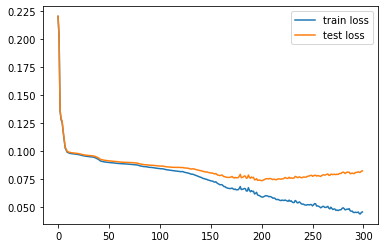

In [13]:
# plot train and test loss
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")

plt.legend()

random sequence index:  249


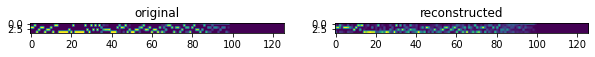

In [14]:
with torch.no_grad():
    outputs = model(train_set.dataset[train_set.indices])
#visualize the results for a random sequence
rand_seq = np.random.randint(0, len(train_set.indices))
print("random sequence index: ", rand_seq)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(train_set.dataset[train_set.indices][rand_seq])
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(outputs[rand_seq])
plt.title("reconstructed")
plt.show()

random sequence index:  52


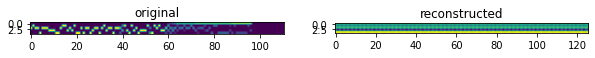

In [95]:
#visualize the results for a random sequence
with torch.no_grad():
    outputs = model(test_set.dataset[test_set.indices])
rand_seq = np.random.randint(0, len(test_set.indices))
print("random sequence index: ", rand_seq)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_set.dataset[test_set.indices][rand_seq])
plt.title("original")
plt.subplot(1, 2, 2)
plt.imshow(outputs[rand_seq])
plt.title("reconstructed")
plt.show()

In [489]:
color_map = {"splicing": 1, "3UTR":0}
labels = [color_map[i] for i in non_redundant_labels_balanced]
len(labels)


711

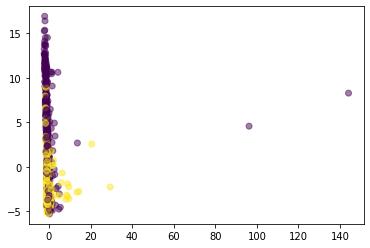

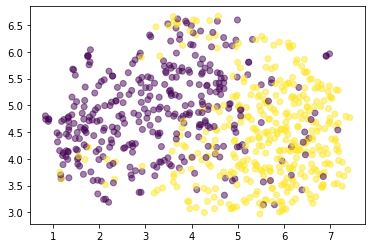

In [494]:
pca = PCA(n_components=2)
with torch.no_grad():
    outputs = input_seqs.flatten(start_dim=1).cpu()
    # scale the data using standard scaler
    scaler = StandardScaler()
    outputs = scaler.fit_transform(outputs)
    outputs = pca.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()

# perform umap on raw data
reducer = umap.UMAP()
with torch.no_grad():
    outputs = input_seqs.flatten(start_dim=1)
    outputs = scaler.fit_transform(outputs)
    outputs = reducer.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()

In [487]:
# perform pca on the bottleneck layer
pca = PCA(n_components=2)
with torch.no_grad():
    outputs = model.encode(input_seqs)
    outputs = outputs.numpy()
    outputs = pca.fit_transform(outputs)
    scaler = StandardScaler()
    outputs = scaler.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()
reducer = umap.UMAP()
with torch.no_grad():
    outputs = model.encode(input_seqs)
    outputs = reducer.fit_transform(outputs)
    plt.scatter(outputs[:,0], outputs[:,1], c = labels, alpha=0.5)
    plt.show()

AttributeError: 'CNN' object has no attribute 'encode'

In [510]:
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(non_redundant_labels_balanced)
labels_tensor = torch.tensor(label_encoded).long()
label_mapping = dict(zip(label_encoder.transform(label_encoder.classes_), label_encoder.classes_))
label_mapping

{0: '3UTR', 1: 'splicing'}

In [511]:
from neural import CNN

In [512]:
if torch.cuda.is_available():
    print("CUDA is available.")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))  # Get name of the first GPU
    print("CUDA version:", torch.version.cuda)
    device = torch.device("cuda")

else:
    print("CUDA is not available.")
    device = torch.device("cpu")

CUDA is available.
Number of available GPUs: 1
CUDA device name: Tesla V100-PCIE-32GB
CUDA version: 12.1


In [513]:
# X = torch.from_numpy(X).float()
X = input_seqs.to(device)
y = labels_tensor.to(device)

num_channels = X.shape[1]
num_classes = len(label_encoder.classes_)
max_lengh = X.shape[-1]

dataset = torch.utils.data.TensorDataset(X, y)

#split train, test, val
train_size = int(0.8 * len(dataset))
test_size = int(0.1 * len(dataset))
val_size = len(dataset) - train_size - test_size
torch.manual_seed(1809)
train_dataset, test_dataset, val_dataset = \
    torch.utils.data.random_split(dataset, [train_size, test_size, val_size])

# create a dataloader
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=False)

In [514]:
#lr=0.0001
#dropout = 0.3
#out_channels = 24
#kernel_size = 11
#val loss = 0.033388595137512314

In [515]:
# create a model, loss function and optimizer
out_channels = 24
kernel_size = 11
model = CNN(in_channels=num_channels, out_channels = out_channels, kernel_size = kernel_size, \
            num_classes=num_classes, max_length = max_lengh, dropout = 0.2, pooling = 6)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)
# train the model
num_epochs = 400
train_loss = []
val_loss = []
for epoch in range(num_epochs):
    model.train()
    train_running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    train_loss.append(train_running_loss/len(train_dataloader))
    # evaluate the model
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(val_dataloader, 0):
            inputs, labels_ = data
            outputs = model(inputs)
            loss = criterion(outputs, labels_)
            val_running_loss += loss.item()
    val_loss.append(val_running_loss/len(val_dataloader))
    if epoch%10 == 0:
        print(f"Epoch {epoch+1}, \nTrain loss: {train_running_loss/len(train_dataloader)}")
        print(f"Validation loss: {val_running_loss/len(val_dataloader)}")


5
Epoch 1, 
Train loss: 0.6994982866140512
Validation loss: 0.6794733934932284
Epoch 11, 
Train loss: 0.5912878724244924
Validation loss: 0.5763007667329576
Epoch 21, 
Train loss: 0.531891261614286
Validation loss: 0.5326811704370711
Epoch 31, 
Train loss: 0.4962269521676577
Validation loss: 0.5044071310096316
Epoch 41, 
Train loss: 0.4702827769976396
Validation loss: 0.4826674891842736
Epoch 51, 
Train loss: 0.44660085439682007
Validation loss: 0.4634775718053182
Epoch 61, 
Train loss: 0.42323936957579394
Validation loss: 0.44562043415175545
Epoch 71, 
Train loss: 0.40410358355595516
Validation loss: 0.4296552124950621
Epoch 81, 
Train loss: 0.3884530768944667
Validation loss: 0.41350257396698
Epoch 91, 
Train loss: 0.36198523273834815
Validation loss: 0.3975897812181049
Epoch 101, 
Train loss: 0.3437966770850695
Validation loss: 0.3840209080113305
Epoch 111, 
Train loss: 0.32416763236889473
Validation loss: 0.3735193411509196
Epoch 121, 
Train loss: 0.31464827289948094
Validation los

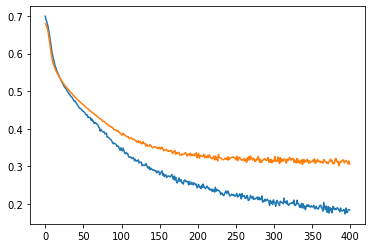

In [516]:
plt.plot(train_loss)
plt.plot(val_loss)

In [432]:
non_redundant_labels_balanced[-9]

'splicing'

In [433]:
inputs.shape

torch.Size([11, 5, 126])

In [434]:
input_seqs[0:2].shape

torch.Size([2, 5, 126])

In [435]:
test_index = -9

In [454]:
seqs = [input_seqs[test_index,:,20:].permute(1,0), \
        input_seqs[test_index,:,15:].permute(1,0), \
        input_seqs[test_index,:,:].permute(1,0)]
test_change = pad_sequence(seqs, True, 0).permute(0,2,1)


In [455]:
outputs = model(test_change.to(device))
_, predicted = torch.max(outputs.data, 1)
predicted

tensor([0, 1, 1], device='cuda:0')

In [438]:
attributions, delta = ig.attribute(test_change.to(device), target=1,\
                                   return_convergence_delta=True)

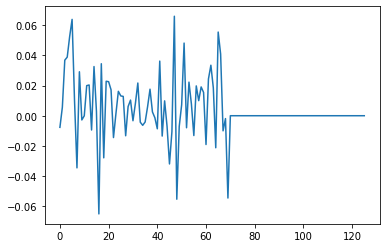

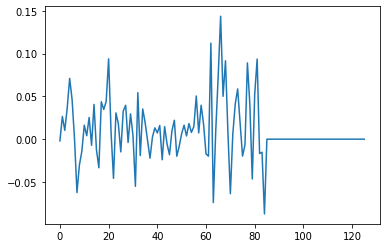

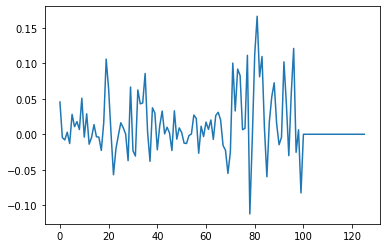

In [456]:
plt.plot(attributions[0].sum(0).cpu())
plt.show()
plt.plot(attributions[1].sum(0).cpu())
plt.show()

plt.plot(attributions[2].sum(0).cpu())
plt.show()


torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([32, 5, 130]) torch.Size([32])
torch.Size([4, 5, 130]) torch.Size([4])
Accuracy: 85.0%


Text(33.0, 0.5, 'True')

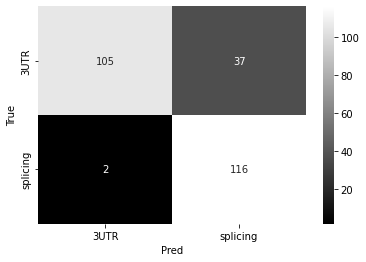

In [517]:
model.eval()
correct = 0
total = 0
y_true = []
y_pred = []
test_inputs = []
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels_ = data
        test_inputs.extend(inputs)
        print(inputs.shape, labels_.shape)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels_)
        y_pred.extend(predicted)
        total += labels_.size(0)
        correct += (predicted == labels_).sum().item()
print(f"Accuracy: {100 * correct / total}%")

y_true = [i.cpu().numpy().item() for i in y_true]
y_pred = [i.cpu().numpy().item() for i in y_pred]
failed_predictions = torch.tensor(y_pred) - torch.tensor(y_true) != 0
failed_indices = [i for i, value in enumerate(failed_predictions) if value]

cm = metrics.confusion_matrix(y_true, y_pred)
col_labels = label_mapping.values()
row_labels = label_mapping.values()

sns.heatmap(cm, xticklabels=col_labels, yticklabels=row_labels, annot=True, fmt='d', cmap="gray")
plt.xlabel('Pred')
plt.ylabel('True')

In [106]:
non_redundant_msa[0].aligned_seqs

['GTGAAACCCTGTCTCTACTAAAAATACAAAAAATTAGCCGGGCGTGGTGGCGGGCGCCCGTAATCCCAGCTACTCGGGAGGCTGAGGCAGGAGAATGGCG--',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAA-TTAGCCAGATGTGGTGGCACACACCTGTAATCCCAGCTACTCAGGAGGCTGAGGCAGGAGAATTGCTT-',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAA-TTAGCCGAGCGTGGTGACACACGCCTGTAATCCCAGCTACTCAGGAGGC-AAGGCAGGAGAATTGCTTG',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAA--TTGTTTAGCTCTGTTTTTCATAATAGAAATAGAAAAGGTAAAATTGCTTTTCTTCTGAAAAGAACAAG',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAA-TTAGCTGGGCATGGTGGCGGGTGCCTATAATCCCAGCTACTTGGGAGGCTGAGGCAGGA----------',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAAATTAGCCAGGCGTGGTGGCGGGCGCCTGTAGTCCCAGCTACTCTGGAGGCTGAGGCAGGAGA--------',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAAATTAGCCGGGTGTGGTGGTGGGCGCCTGTAGTCCCAGCTACTTGGGAGGCTGAGGCAGGAGAATGGT---',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAA-TTAGCCAGGCGTGGTGGC---------------------------------------------------',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA------------------------------------------',
 'GTGAAACCCTGTCTCTACTAAAAATACAAAAAATT

In [107]:
original_labels[80]

'Base_pair_change_6'

In [108]:
np.array(original_labels) == "splicing"

array([False, False, False, ...,  True,  True,  True])

In [530]:
num_compactors = [len(msa.aligned_seqs) for msa in non_redundant_msa]
avg_len_compactors = [msa.mean_length for msa in non_redundant_msa]
max_len_compactors = [msa.max_length for msa in non_redundant_msa]


In [531]:
df_feat.groupby("label").mean()

,length
label,
3UTR,97.247209
splicing,99.161725


<Axes: xlabel='label', ylabel='length'>

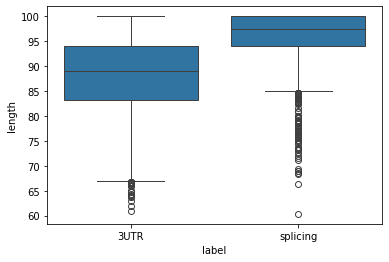

In [535]:
df_feat = pd.DataFrame([avg_len_compactors, non_redundant_labels]).T
df_feat.columns = ["length", "label"]
df_feat
sns.boxplot(data =df_feat, x = "label", y = "length")

In [111]:
non_redundant_msa[2].aligned_seqs

['TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACCTGCCGAGTCTTATCTCGTATGCCGTCTTCTG',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACTTCCACAATCTGATCTCGTATGCCGTCTT---',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACATGTGTATCCTCATCTCGTATGCCGTCTTCTG',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACCCCATCTTCTCCATCTCGTATGCCGTCTTCTG',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACTTGCTAATAGTGATCTCGTATGCCGTCTTCT-',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAGCACTTGCCCGATCTCGTATGCCGTC-----',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACAACTAAAGGTCTATCTCGTATGCCGTCTTCTG',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACTGAAGACC------------------------',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACCAATACGAGTGAATCTCGTATGCCGTC-----',
 'TACATGGGAAGCAGTGGTATCAACGCCTGTCTCTTATACACATCTCCGAGCCCACGAGACCGGATAACAATAATCTCGTATGCCGTCTTCTG']

In [108]:
non_redundant_msa[-1].aligned_seqs

['TGCCTGTGCAACTGTCGGAAATAGAGGCTTCGTGTTTGGAGGCAGATATCGAGATGCTAGAATGAATGATCTTCACTATCTTAATCTGGATACATG',
 'TGCCTGTGCAACTGTCGGAAATAGAGGCTTCGTGTTTGGAGGCAGATATCGAGTAAGTATT-CAAACGA-CTTCAATGACTT--------------']

In [106]:
non_redundant_labels[-1]

'splicing'

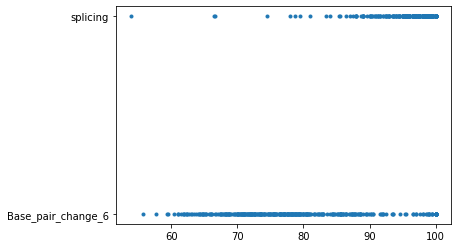

In [53]:
plt.scatter(avg_len_compactors, non_redundant_labels, marker = ".")

In [41]:
all_msa[-4].aligned_seqs

['TTCTCCTGTCTCAGCCTCCCAAGTAGCTGGAATTACAGGGACCCGCCACCACGCCCGGCTAATTTTTTTGTGTGGTTTTAGTAGAGGTGGGGTTTC-',
 'TTCTCCTGTCTCAGCCTCCCAAGTAGCTGGGATTACAGGCATGCACCAGCACACCCAGCTAATTTT-----GTATTTTTAGTAGAGACAGGGTTT--',
 'TTCTCCTGTCTCAGCCTCCCAAGTAGCTGGGACTACAGGCGCCCACCATCATGCCCGGCTAATTTTTT---GTATTTTTAATAGAGATAGGG-----',
 'TTCTCCTGTCTCAGCCTCCCAAGTAGCTGGGATTACAGGCACACACTGCCACGCCTGGTTAATTTTT----GCATTTTTAGTAGAGACAGGGTTTCA',
 'TTCTCCTGTCTCAGCCTCCCAAGTAGCTGGGATTACAGGTGCCCGCCACCA----------------------------------------------',
 'TTCTCCTGTCTCAGCCTCCCAAGTAGCTGGGACTACAGGCGCCCGCCACCAC---------------------------------------------']

In [518]:
ig = IntegratedGradients(model)
attributions, delta = ig.attribute(torch.stack(test_inputs, dim=0), target=1,\
                                   return_convergence_delta=True)


In [519]:
attribution_score = attributions.sum(dim=1).sum(dim=-1)

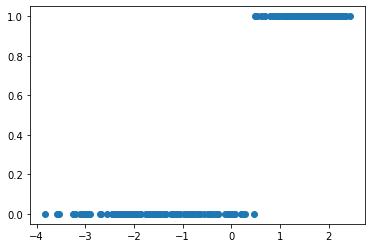

In [520]:
plt.scatter(attribution_score.cpu(), torch.tensor(y_pred).cpu())

In [213]:
np.array(y_pred)

array([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1])

In [217]:
non_redundant_msa[data_index].aligned_seqs

['CAGGGATTTCCTACCATTAAGATTTTT-GGATCCAACAAAAACAGACCAGAAGATTACCAAGGTGGCAGAACTGGTGAAGCCATTGTAGATGCTGCGC',
 'CAGGGATTTCCTACCATTAAGATTTTTTGGATCCAACAAAAACAGACCAGAAGATTACCAAGGTGGCAGAACTGGTGAAGCCATTGTAGATGCTGCG-']

99


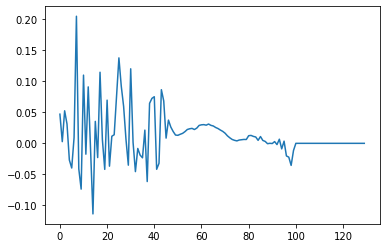

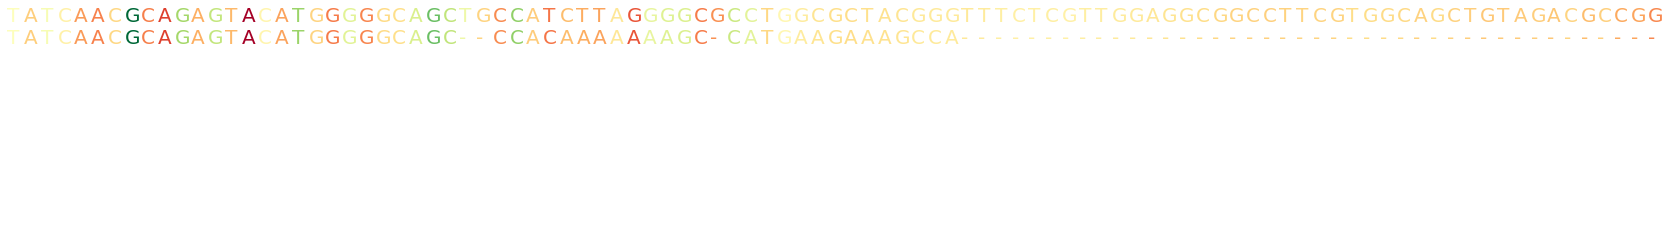

1 1
tensor(1.6275, device='cuda:0', dtype=torch.float64)


In [529]:
index = 5
data_index = test_dataloader.dataset.indices[index]
print(len(non_redundant_msa[data_index].aligned_seqs[0]))
plt.plot(attributions.sum(dim=1)[index].cpu())
seq_len = len(non_redundant_msa[data_index].aligned_seqs[0])
viz_sequence_importance(non_redundant_msa[data_index].aligned_seqs, attributions.sum(dim=1)[index].cpu()[:seq_len])
non_redundant_msa[data_index].aligned_seqs
print(y_pred[index], y_true[index])
print(attributions.sum(dim = [1,2])[index])

In [281]:
label_mapping

{0: '3UTR', 1: 'splicing'}

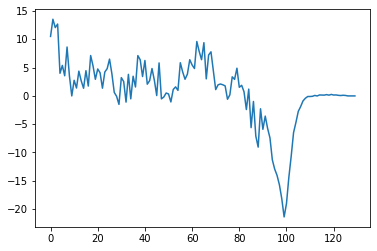

In [521]:
plt.plot(attributions.sum(dim = [0, 1]).cpu())

In [169]:
len(non_redundant_msa[data_index].aligned_seqs[0])

100

In [199]:
def viz_sequence_importance(seqs, attributions):
    # Create a figure and axis
    fig, ax = plt.subplots()
    attributions = np.array(attributions)
    attributions -= min(attributions)
    attributions/= max(attributions)
#     attributions -= 0.5
#     attributions*=4
    # Plot each string with characters colored according to the list of numbers
    for si, string in enumerate(seqs):
        for idx, char in enumerate(string):
            color_index = idx % len(attributions)  # Cycle through numbers list
            ax.text(idx * 0.05, 1 - si * 0.2, char, 
                    color=plt.cm.RdYlGn(attributions[color_index]), fontsize=20)
    ax.set_ylim(-1, 1)
    ax.axis('off')
    plt.show()


In [159]:
np.array(y_true)

array([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1])

In [166]:
np.array(y_pred)

array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 0, 1])

In [119]:
for i in failed_indices:
    print(attribution_score[i])
    print(i)

tensor(-1.1681, device='cuda:0', dtype=torch.float64)
3
tensor(-1.5068, device='cuda:0', dtype=torch.float64)
5
tensor(0.9797, device='cuda:0', dtype=torch.float64)
19
tensor(0.6691, device='cuda:0', dtype=torch.float64)
20
tensor(0.0259, device='cuda:0', dtype=torch.float64)
25


In [120]:
np.argmax(attributions.sum(dim=1)[57].cpu())

tensor(75)

In [121]:
plt.plot(attributions.sum(dim=1)[79].cpu())

IndexError: index 79 is out of bounds for dimension 0 with size 71

In [89]:
attribution_score > 10

tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False, False, False,
        False, False, False,  True, False, False,  True, False, False, False,
        False, False,  True,  True, False, False, False,  True, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False,  True, False, False,
        False, False, False, False, False, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, 

In [43]:
def plot_input(input_x):
    plt.imshow(input_x.cpu())

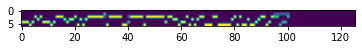

In [105]:
plot_input(test_inputs[57])

In [112]:
test_dataset.indices[79]

859

In [62]:
test_dataset.dataset.tensors[1].shape

torch.Size([1314])

In [48]:
len("TCGAGACCATCCTGGCTAACAAGGTGAAACCCCGTCTCTACTAAAAATACAAAAA")

55

In [110]:
'GGGTGACAGGGTGAAACGCCATCTCAAAAAA-TAAAAATTGAAAAATAAAAAAAGAACCTGGATCTCAATTTAATTTTTCATATTCTTGCAATGAAATGGA'[90:95]

'AATGA'

In [113]:
df_aligned.groupby("anchor_index").agg(list).aligned_compactor.to_list()[859]

['ATCGAGCATGCCGAGTTCTCGGGGAACCTGTATGGCACGAGCAAGGTGGCGGTGCAGGCCGTGCAGGCCATGAACCGCATCTGTGTGCTGGACGTGGA-',
 'ATCGAGCATGCCGAGTTCTCGGGGAACCTGTATGGCACGAGCAAGGTGGCGGTGCAGGCTGTGCAGGCCATGAACCGCATCTGTGTGCTGGACGTGGAC']

In [52]:
attributions.sum()

tensor(-2.7749, device='cuda:0', dtype=torch.float64)

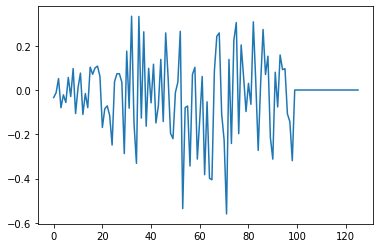

In [50]:
plt.plot(attributions.sum(dim = 1).squeeze().cpu())

In [97]:
failed_predictions = torch.tensor(y_pred) - torch.tensor(y_true) != 0
failed_indices = [i for i, value in enumerate(failed_predictions) if value]
failed_indices

[3, 13, 16, 24, 25, 31, 57, 79, 101, 129]

In [17]:
print(metrics.confusion_matrix(torch.tensor(y_true), torch.tensor(y_pred)))


[[179  56]
 [ 10  96]]


In [31]:
wrong_index = 79

In [32]:
y_pred[wrong_index]

tensor(1, device='cuda:0')

In [33]:
y_true[wrong_index]

tensor(0, device='cuda:0')

In [91]:
test_dataset.indices[wrong_index]

1028

In [36]:
failed_case = df_aligned.groupby("anchor_index").agg(list).compactor_valid.to_list()[79]

In [44]:
for seq in df_aligned.compactor_valid.to_list():
    if seq.find("GGTGCAGGCCGTGCAGGCCATGAACCGCATCTGT") > -1 :
        print(seq)

ATCGAGCATGCCGAGTTCTCGGGGAACCTGTATGGCACGAGCAAGGTGGCGGTGCAGGCCGTGCAGGCCATGAACCGCATCTGTGTGCTGGACGTGGA
CGACTTCATCGAGCATGCCGAGTTCTCGGGGAACCTGTATGGCACGAGCAAGGTGGCGGTGCAGGCCGTGCAGGCCATGAACCGCATCTGTGTGC


In [92]:
df_aligned.groupby("anchor_index").agg(list).aligned_compactor.to_list()[1028]

['ATGGCTAAACCCTGACCCATCTCAGAAGCAGAATCTCCTAGCCCCACAGAATGCTGTGTCC---TCTGAAGAAACCAATGACTTTAAACAAGAGACCCTTCC',
 'ATGGCTAAACCCTGACCCATCTCAGAAGCAGAATCTCCTAGCCCCACAGACCCTTCCAAGTAAGTCCAACGAAAGCCATGACCACATGGATGATATG-----']

In [91]:
failed_case

['ATCGAGCATGCCGAGTTCTCGGGGAACCTGTATGGCACGAGCAAGGTGGCGGTGCAGGCCGTGCAGGCCATGAACCGCATCTGTGTGCTGGACGTGGA',
 'ATCGAGCATGCCGAGTTCTCGGGGAACCTGTATGGCACGAGCAAGGTGGCGGTGCAGGCTGTGCAGGCCATGAACCGCATCTGTGTGCTGGACGTGGAC']

In [64]:
y_true[62]

tensor(1, device='cuda:0')

In [46]:
y_true[48]

tensor(0, device='cuda:0')

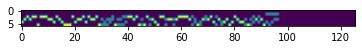

In [111]:
plt.imshow(test_inputs[106].cpu())